In [1]:
# Activate the library
import Pkg
Pkg.activate("../")

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [2]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Statistics", "Random", "QuadGK", "Plots", "LaTeXStrings", "OrdinaryDiffEq"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

# Resonance Fluorescene
We'll consider the model as presented in Wiseman's books (equation 3.31) and Molmer (2012).

## System and simulation setup

In [3]:
function rf_de!(dr, r, p, t)
    gamma = QuTaM.rf_gamma
    delta = QuTaM.rf_delta
    omega = QuTaM.rf_omega
    dr[1] = -0.5*gamma*r[1] - 2*delta*r[2]
    dr[2] = 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3]
    dr[3] = 2*omega*r[2] - gamma*(r[3] + 1)
end

rf_de! (generic function with 1 method)

In [4]:
sys = QuTaM.rf_sys
params = QuTaM.rf_params

SimulParameters(psi0=ComplexF64[1.0 + 0.0im, 0.0 + 0.0im]
nsamples=75000
seed=1
ntraj=250)
multiplier=3.0
tf=25.0
dt=0.001
eps=0.001)

In [5]:
# Analytical Solution
r0 = [0.0; 0.0; -1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

## Sampling trajectories 

In [6]:
sample_clicks = QuTaM.run_trajectories(sys, params)

Sampling... 100%|████████████████████████████████████████| Time: 0:00:21


250-element Vector{Vector{DetectionClick}}:
 [DetectionClick(0.3880051734023123, 1), DetectionClick(4.595061267483566, 1), DetectionClick(2.215029533727116, 1), DetectionClick(4.018053574047654, 1), DetectionClick(4.876065014200189, 1), DetectionClick(29.438392511900158, 1)]
 [DetectionClick(2.6140348537980507, 1), DetectionClick(42.94057254096721, 1)]
 [DetectionClick(8.794117254896731, 1), DetectionClick(4.150055334071121, 1), DetectionClick(2.8920385605141403, 1), DetectionClick(2.0860278137041828, 1), DetectionClick(3.4480459739463196, 1), DetectionClick(2.6810357471432953, 1), DetectionClick(1.6660222136295153, 1)]
 [DetectionClick(15.937212496166616, 1), DetectionClick(0.668008906785424, 1), DetectionClick(2.677035693809251, 1), DetectionClick(7.485099801330684, 1)]
 [DetectionClick(8.358111441485885, 1), DetectionClick(3.527047027293697, 1), DetectionClick(1.5540207202762706, 1), DetectionClick(14.834197789303857, 1)]
 [DetectionClick(2.2250296670622274, 1), DetectionClick(7.580

In [7]:
## Average Simulation ################3
# Now from each trajectory, generate the states at the given times
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, sys.NLEVELS, ntimes, params.ntraj)
@time begin
for n in 1:params.ntraj
    sample[:, :, n] = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
end

end 

  0.809615 seconds (3.69 M allocations: 431.904 MiB, 9.57% gc time, 4.10% compilation time)


## Bloch Coordinates 

In [8]:
# Expectation value of the Pauli matrices
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[:,tn, j], sigma[k] * sample[:, tn, j])   # Drop the extra dimension
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

  0.857900 seconds (7.49 M allocations: 333.734 MiB, 5.77% gc time, 6.95% compilation time)


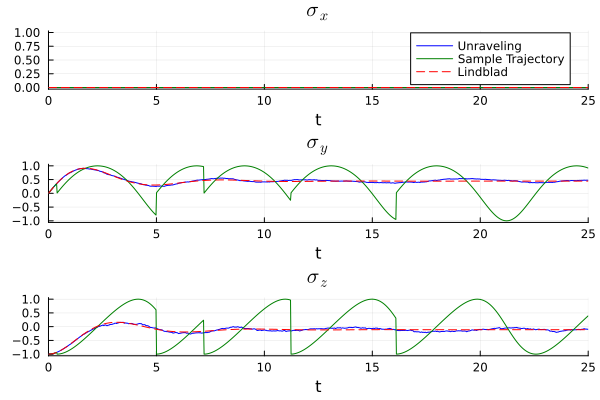

In [9]:
p1 = plot(t_given, r_avg[:, 1], label="Unraveling", title=L"\sigma_x", seriescolor=:blue)
plot!(t_given, r_sample[:,1, 1], label="Sample Trajectory", seriescolor=:green)
plot!(sol, idxs =(0, 1), label="Lindblad", seriescolor=:red, line=:dash)

p2 = plot(t_given, r_avg[:, 2], title=L"\sigma_y", seriescolor=:blue)
plot!(t_given, r_sample[:,2, 1], seriescolor=:green)
plot!(sol, idxs =(0, 2),  legend=false,  seriescolor=:red, line=:dash)

p3 = plot(t_given, r_avg[:, 3], title=L"\sigma_z", seriescolor=:blue)
plot!(t_given, r_sample[:,3, 1],  seriescolor=:green)
plot!(sol, idxs =(0, 3), legend=false, seriescolor=:red, line=:dash)

plot(p1, p2, p3, layout=(3,1))


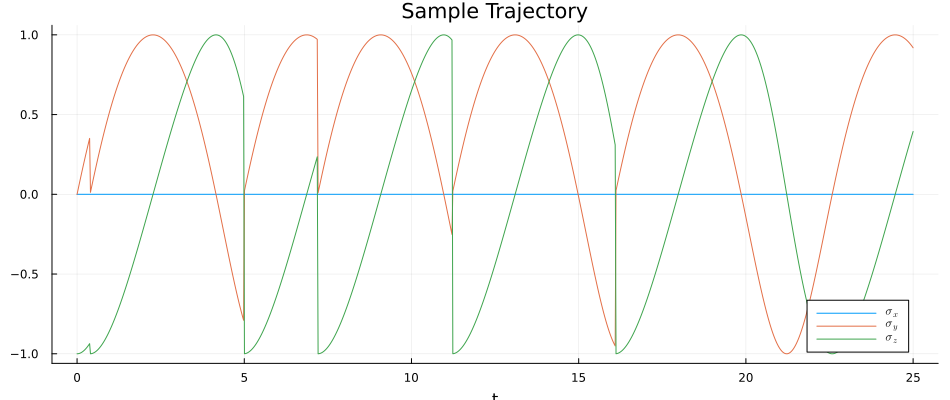

In [10]:
plot(t_given, [r_sample[:,1, 1], r_sample[:,2, 1], r_sample[:,3, 1]], label= [L"\sigma_x" L"\sigma_y" L"\sigma_z"])
plot!(title="Sample Trajectory", xlabel="t", size=(950,400))

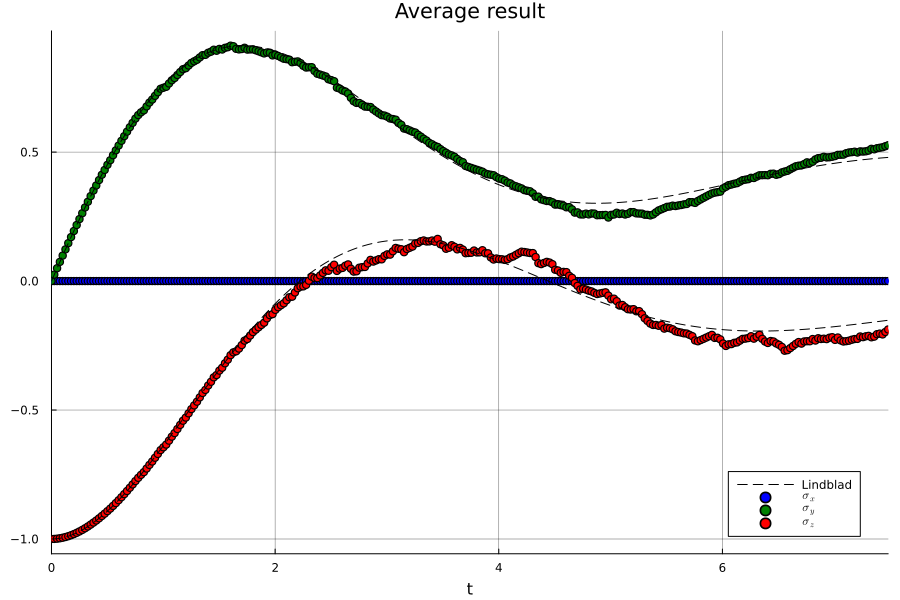

In [11]:
index_range = 1:300

plot(sol[index_range], idxs =(0, 1), seriescolor="black", label="Lindblad",  line=:dash)
scatter!(t_given[index_range], r_avg[index_range, 1],  label=L"\sigma_x" , seriescolor=:blue)

scatter!(t_given[index_range], r_avg[index_range, 2],  label=L"\sigma_y" , seriescolor=:green)
plot!(sol[index_range], idxs =(0, 2), seriescolor="black", label=:false,  line=:dash)

scatter!(t_given[index_range], r_avg[index_range, 3],  label=L"\sigma_z" , seriescolor=:red)
plot!(sol[index_range], idxs =(0, 3), seriescolor="black", label=:false,  line=:dash)

plot!(title="Average result", xlabel="t", grid=:true, gridalpha=0.6, size=(900,600))

## Waiting Time Distribution

In [12]:
import HypothesisTests, Distributions

# Define the analytical result for the WTD
struct WTD_rf <: Distributions.ContinuousUnivariateDistribution
    omega::Float64
    gamma::Float64

end

function Distributions.support(d::WTD_rf)
    return Distributions.Interval(0, Inf)
end

function Distributions.pdf(d::WTD_rf, tau::Real)
        # Replace with your custom formula
        gamma = d.gamma
        omega = d.omega
        return (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    end

function Distributions.cdf(d::WTD_rf, t::Real)
    pdf(tau) = (16*d.gamma*d.omega^2)*exp(-0.5*d.gamma*tau) * sin(0.25*tau*sqrt(16*d.omega^2-d.gamma^2))^2/(-d.gamma^2+16*d.omega^2)
    return quadgk(pdf, 0, t, rtol=1e-8)[1]
end

################# TODO: THIS IS A VERY INNEFICIENT SAMPLING
function Base.rand(rng::AbstractRNG, d::WTD_rf)
    # Use inversion sampling
    alpha = rand()
    t = 0
    dt = 0.001 # This is a magic number, the point is that this matches the dt in rf_params
    while Distributions.cdf(d, t) < alpha
        t = dt + t
    end
    return t  # Return a sample
end



In [13]:
f = WTD_rf(QuTaM.rf_gamma, QuTaM.rf_omega) # Instance of the WTD
println("Sampling from the analytical WTD\n")
@time begin
    f_sample = rand(f, 500) # Sample from the WTD
end;


Sampling from the analytical WTD

  2.322460 seconds (1.65 M allocations: 198.626 MiB, 2.76% gc time, 47.88% compilation time)


In [14]:
tau_sample = Vector{Float64}()
@time begin
for traj in sample_clicks
    if !isempty(traj)
        for click in traj
            push!(tau_sample, click.time)
        end 
    else
        continue
    end 
end 
end

  0.045614 seconds (7.15 k allocations: 225.062 KiB, 99.07% compilation time)


In [15]:
# Goddness of fit
HypothesisTests.ApproximateTwoSampleKSTest(tau_sample, f_sample)

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0367206

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.6826

Details:
    number of observations:   [1607,500]
    KS-statistic:              0.7170846245389972


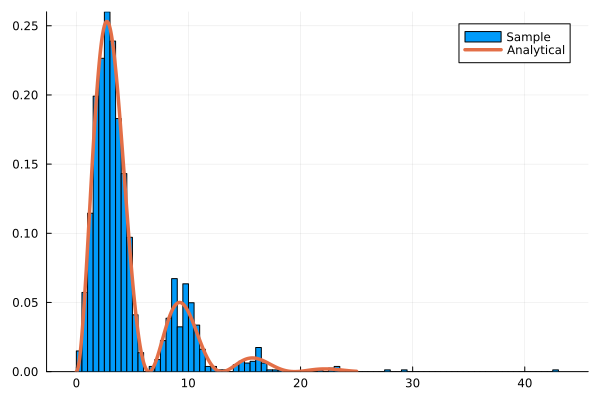

In [16]:
histogram(tau_sample, normalize=:pdf, label="Sample")
plot!(t_given, Distributions.pdf.(f, t_given), label="Analytical", linewidth=3.5)
